we're using the navier stokes equation here however without explicitly simulating pressure. turns out simulating pressure is especially difficult due to... reasons? i think we dont have an easy equation to calculate pressure like we do for other things and it's easier to calculate what pressure should be rather than what it is which is interesting.

so the general idea is using the navier stokes equation but instead of calculating pressure, solve the navier stokes equation ignoring pressure. the result of that equation tells us what our wind movement in x,y looks like. we can then use that info to solve the poisson equation. from my understanding the poisson equations finds us pressure values that would make sense in the context of weather. so for example if theres a lot of wind moving to the right it will assign the right a high pressure value and the surrounding areas lower pressure.

with these "solved for" pressure values, we actually update the x,y wind movement with the pressure values to get a realistic? simulation of wind

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
timestep = 1
cellSize = 1

viscosity = 10**-5
density = 1.2

In [14]:
xWindMovement = np.arange(1, 26).reshape(5, 5)
yWindMovement = np.arange(1, 26).reshape(5, 5)

In [4]:
def calculateNeighbors(data):
    easternNeighbor = np.hstack((data[:, 1:], np.zeros((5,1))))
    westernNeighbor = np.hstack((np.zeros((5,1)), data[:, :-1]))
    northernNeighbor = np.vstack((np.zeros(5), data[:-1]))
    southernNeighbor = np.vstack((data[1:], np.zeros(5)))

    return (northernNeighbor, easternNeighbor, southernNeighbor, westernNeighbor)

def divergence(xVelocity, yVelocity):
    _,e,_,w = calculateNeighbors(xVelocity)
    n,_,s,_ = calculateNeighbors(yVelocity)
    return (e-w)/cellSize*2 + (n-s)/cellSize*2

In [5]:
n,e,s,w = calculateNeighbors(xWindMovement)
xAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
xDiffusion = viscosity * ((e - 2*xWindMovement + w)/(cellSize**2) + (n - 2*xWindMovement + s)/(cellSize**2))
xPredictedWind = xWindMovement + timestep * (xAdvection + xDiffusion)

n,e,s,w = calculateNeighbors(yWindMovement)
yAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
yDiffusion = viscosity * ((e - 2*yWindMovement + w)/(cellSize**2) + (n - 2*yWindMovement + s)/(cellSize**2))
yPredictedWind = yWindMovement + timestep * (yAdvection + yDiffusion)

In [6]:
prevPressure = np.full((5,5), np.inf)
pressure = np.zeros((5, 5))
stabalizedThresold = 0.001
numIters = 0
while np.abs(pressure - prevPressure).max() > stabalizedThresold:
    summedNeighborPressure = np.add.reduce(np.array(calculateNeighbors(pressure)))
    cellDivergence = divergence(xPredictedWind, yPredictedWind)
    currentPressure = (summedNeighborPressure - cellDivergence)/4

    prevPressure = pressure
    pressure = currentPressure
    numIters += 1

print(f'After {numIters} iterations...')
print(pressure)

After 79 iterations...
[[ -51.81513362  -59.30903544  -46.88127949  -15.02611314   78.51319075]
 [-163.952224   -190.54109838 -171.19177932 -125.73785353   83.07819115]
 [-337.45371372 -423.7138497  -407.60950528 -373.81456776  -20.46370233]
 [-532.15035116 -729.2535408  -741.72136429 -781.45018929 -341.12000267]
 [-135.8947598  -465.43041302 -484.57432118 -633.14731738 -512.56664877]]


In [7]:
n,e,s,w = calculateNeighbors(pressure)

xPressureGradient = (e-w)/(2*cellSize)
yPressureGradient = (n-s)/(2*cellSize)

# we multiply by timestep to scale the pressure according to timestep - more timesteps passing = greater movement as a result
# we divide by density to scale the pressure according to how difficult it is to move air. for a very dense substance, it takes greater force, greater pressure to move it compared to low density fluid which will move easily
xWindMovement = xPredictedWind - timestep/density * xPressureGradient
yWindMovement = yPredictedWind - timestep/density * yPressureGradient

In [11]:
def plotData(data1, data2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row, 2 columns
    im1 = axes[0].imshow(data1, cmap='viridis')
    axes[0].set_title(title1)
    fig.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(data2, cmap='viridis')
    axes[1].set_title(title2)
    fig.colorbar(im2, ax=axes[1])

    plt.show()

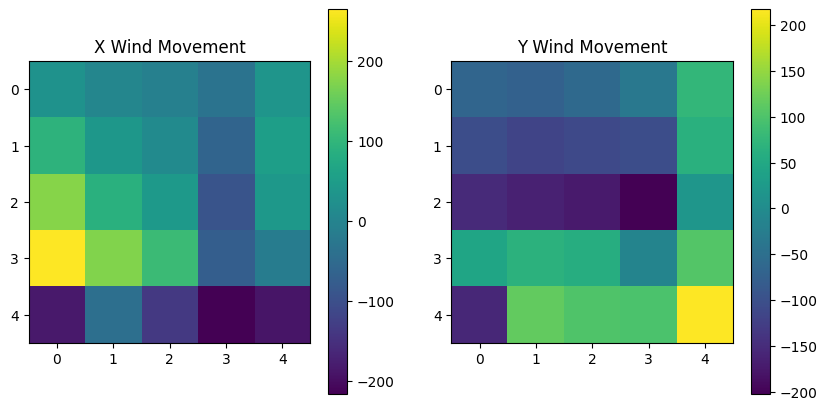

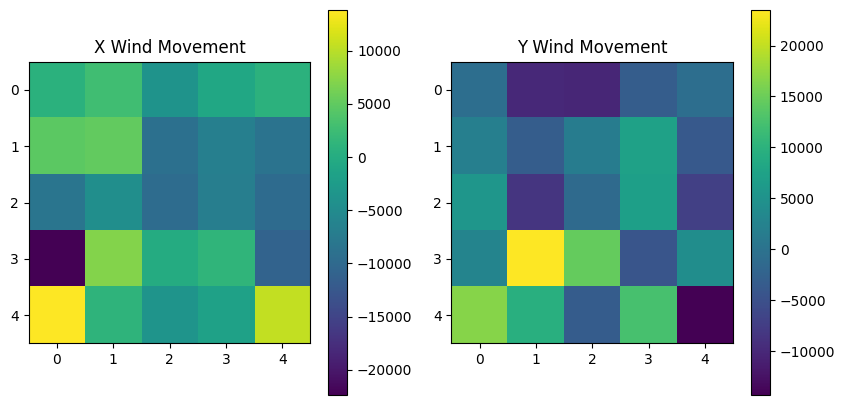

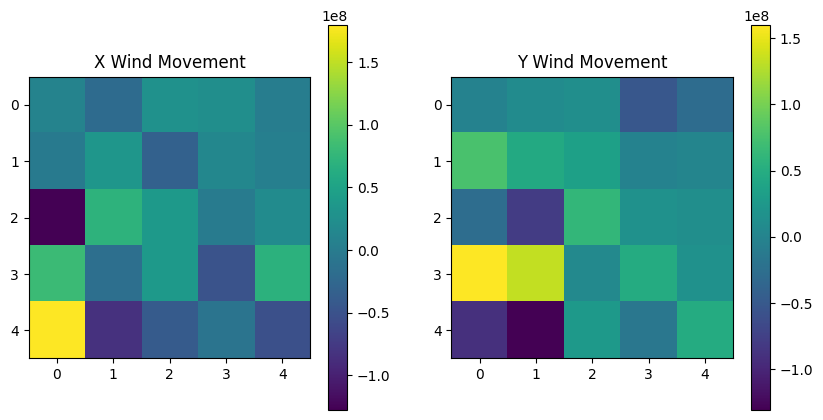

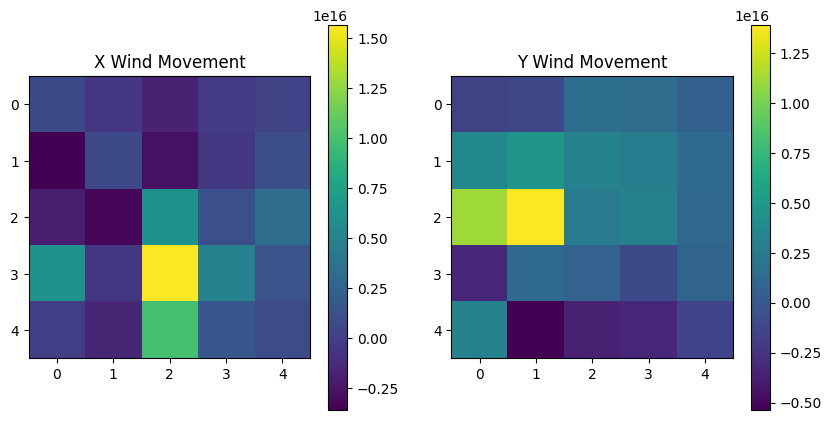

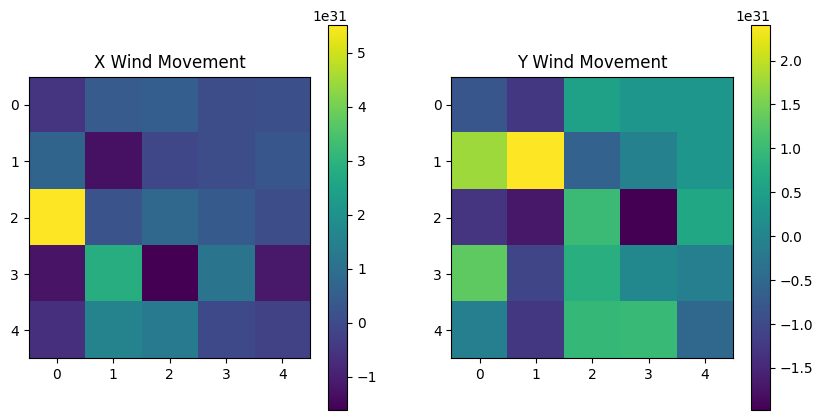

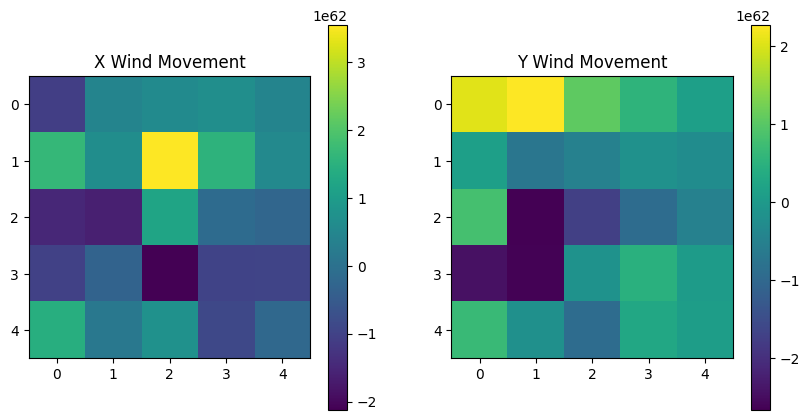

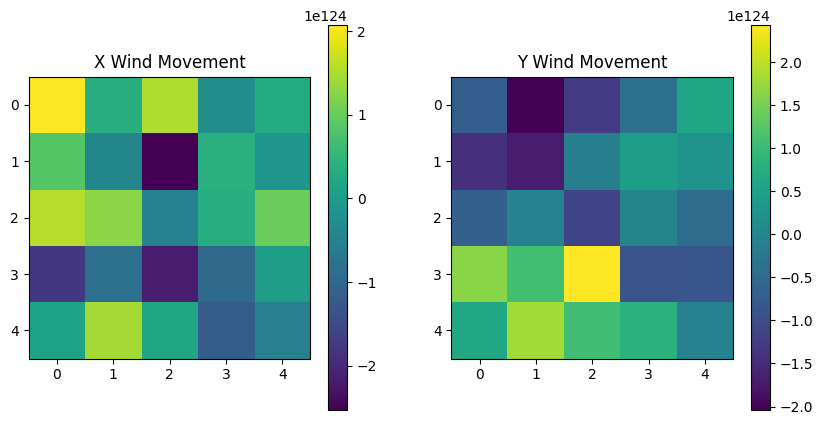

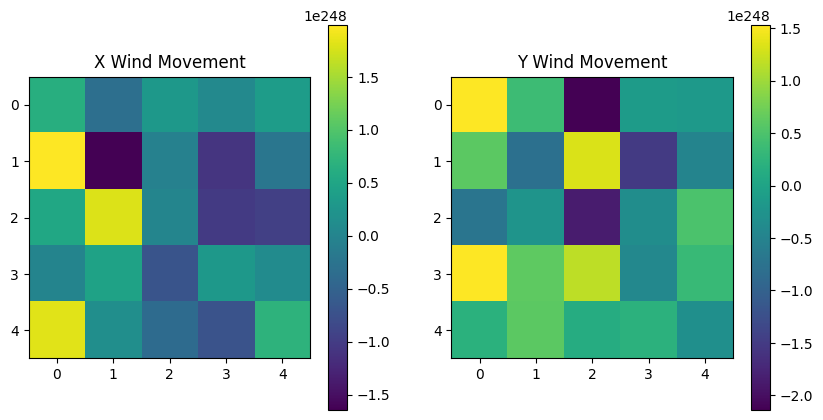

<ipython-input-15-912dbc4fd8ca>:3: RuntimeWarning: overflow encountered in multiply
  xAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
<ipython-input-15-912dbc4fd8ca>:3: RuntimeWarning: invalid value encountered in subtract
  xAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
<ipython-input-15-912dbc4fd8ca>:8: RuntimeWarning: overflow encountered in multiply
  yAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
<ipython-input-15-912dbc4fd8ca>:8: RuntimeWarning: invalid value encountered in subtract
  yAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
<ipython-input-4-6e6eedda8c28>:12: RuntimeWarning: invalid value encountered in subtract
  return (e-w)/cellSize*2 + (n-s)/cellSize*2


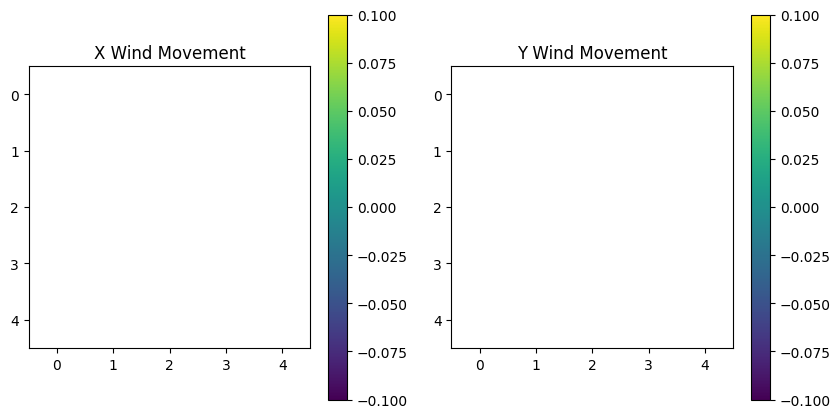

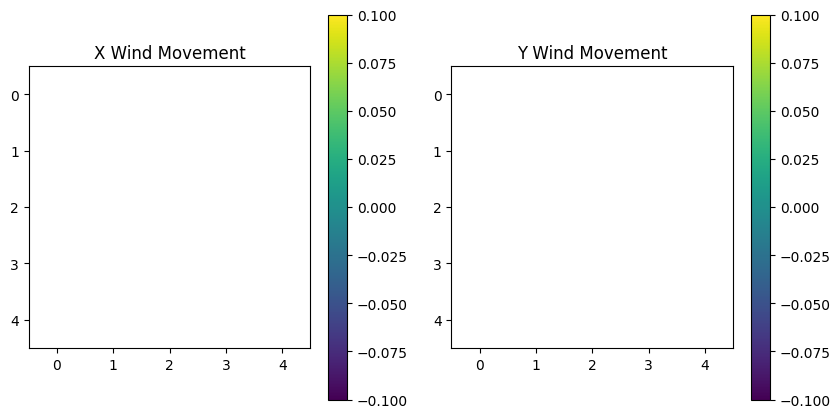

In [15]:
for i in range(10):
    n,e,s,w = calculateNeighbors(xWindMovement)
    xAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
    xDiffusion = viscosity * ((e - 2*xWindMovement + w)/(cellSize**2) + (n - 2*xWindMovement + s)/(cellSize**2))
    xPredictedWind = xWindMovement + timestep * (xAdvection + xDiffusion)

    n,e,s,w = calculateNeighbors(yWindMovement)
    yAdvection = -1 * xWindMovement * (e - w)/(2*cellSize) - yWindMovement * (n - s)/(2*cellSize)
    yDiffusion = viscosity * ((e - 2*yWindMovement + w)/(cellSize**2) + (n - 2*yWindMovement + s)/(cellSize**2))
    yPredictedWind = yWindMovement + timestep * (yAdvection + yDiffusion)

    prevPressure = np.full((5,5), np.inf)
    pressure = np.zeros((5, 5))
    stabalizedThresold = 0.001
    numIters = 0
    while np.abs(pressure - prevPressure).max() > stabalizedThresold:
        summedNeighborPressure = np.add.reduce(np.array(calculateNeighbors(pressure)))
        cellDivergence = divergence(xPredictedWind, yPredictedWind)
        currentPressure = (summedNeighborPressure - cellDivergence)/4

        prevPressure = pressure
        pressure = currentPressure
        numIters += 1

    n,e,s,w = calculateNeighbors(pressure)

    xPressureGradient = (e-w)/(2*cellSize)
    yPressureGradient = (n-s)/(2*cellSize)

    # we multiply by timestep to scale the pressure according to timestep - more timesteps passing = greater movement as a result
    # we divide by density to scale the pressure according to how difficult it is to move air. for a very dense substance, it takes greater force, greater pressure to move it compared to low density fluid which will move easily
    xWindMovement = xPredictedWind - timestep/density * xPressureGradient
    yWindMovement = yPredictedWind - timestep/density * yPressureGradient

    plotData(xWindMovement, yWindMovement, 'X Wind Movement', 'Y Wind Movement')